In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import math, time, sys, os
import numpy as np
from numpy import sqrt,cos,ma
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc
from   matplotlib.backends.backend_pdf import PdfPages
from   matplotlib.patches import Polygon
from   netCDF4 import Dataset as open_ncfile
from matplotlib.pyplot import figure
import scipy
from scipy.ndimage import convolve1d
from scipy.signal import savgol_coeffs, savgol_filter
from scipy.signal._savitzky_golay import _polyder
from scipy.interpolate import griddata
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import colors
import matplotlib.patches as patches
import datetime
from datetime import date, timedelta
import os
import subprocess
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import root_mean_squared_error, r2_score
from math import sqrt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress

In [3]:
years = [f"'{year}'" for year in range(1981, 2101)]
formatted_years = ', '.join(years)
print(formatted_years)

'1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058', '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067', '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076', '2077', '2078', '2079', '2080', '2081', '2082', '2083', '2084', '2085', '2086', '2087', '2088', '2089', '2090', '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099', '2100'


In [4]:
############################################ Input #######################################
data_geoem="/data/inputs/METOCEAN/historical/model/atmos/ENEA/Med-CORDEX/static/"
data_medcordex_ssp245="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_MEDCORDEX/Future/processed_SSP245/"
data_medcordex_ssp585="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_MEDCORDEX/Future/processed_SSP585/"
##########################################################################################

In [5]:
def root_mean_squared_error_calc(true, pred):
    squared_diff = (true - pred) ** 2
    mean_squared_error = np.nanmean(squared_diff)
    return np.sqrt(mean_squared_error)

def r2_score_calc(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    ss_res = np.sum((y_true_filtered - y_pred_filtered) ** 2)
    ss_tot = np.sum((y_true_filtered - np.mean(y_true_filtered)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot)
    return r2

def is_leap_year(year):
    return (year % 4 == 0)

In [7]:
yr_v = ['1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',  '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',  '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',  '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',  '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058', '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067', '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076', '2077', '2078', '2079', '2080', '2081', '2082', '2083', '2084', '2085', '2086', '2087', '2088', '2089', '2090', '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099', '2100']

MSLP_medcordex_ssp245 = []
MSLP_medcordex_ssp585 = []

grid_data = open_ncfile(str(data_medcordex_ssp245)+"/MEDCORDEX_2021_SLP_yearlymean.nc","r")
lat_m = grid_data.variables["lat"][:,:]
lon_m = grid_data.variables["lon"][:,:]

lat_m1 = np.where((lat_m>=29.78) & (lat_m<=48.89), 1, np.nan)
ind1 = np.where((lon_m>=5.03) & (lon_m<=22.92), lat_m1, np.nan)

geoem_data = open_ncfile(str(data_geoem)+"/geo_em.d01.nc","r")
lsm = geoem_data.variables["LANDMASK"][0,:,:]  #Landmask : 1=land, 0=water

ind_lnd = np.where((lsm == 1) & (ind1 == 1), 1, np.nan)
ind_ocn = np.where((lsm == 0) & (ind1 == 1), 1, np.nan)

In [9]:
MSLP_medcordex_ssp245_lnd = []
MSLP_medcordex_ssp245_ocn = []
MSLP_medcordex_ssp585_lnd = []
MSLP_medcordex_ssp585_ocn = []

for year in yr_v:
    MSLP_medcordex_ssp245 = open_ncfile(str(data_medcordex_ssp245)+"/MEDCORDEX_"+str(year)+"_SLP_yearlymean.nc","r")
    MSLP_medcordex_ssp585 = open_ncfile(str(data_medcordex_ssp585)+"/MEDCORDEX_"+str(year)+"_SLP_yearlymean.nc","r")
    MSLP_medcordex_ssp245_d = MSLP_medcordex_ssp245.variables["SLP"][0,:,:]
    MSLP_medcordex_ssp585_d = MSLP_medcordex_ssp585.variables["SLP"][0,:,:]
    
    MSLP_medcordex_ssp245_lnd1 = MSLP_medcordex_ssp245_d*ind_lnd
    MSLP_medcordex_ssp245_ocn1 = MSLP_medcordex_ssp245_d*ind_ocn
    MSLP_medcordex_ssp585_lnd1 = MSLP_medcordex_ssp585_d*ind_lnd
    MSLP_medcordex_ssp585_ocn1 = MSLP_medcordex_ssp585_d*ind_ocn
    
    MSLP_medcordex_ssp245_lnd.append(np.nanmean(MSLP_medcordex_ssp245_lnd1))
    MSLP_medcordex_ssp245_ocn.append(np.nanmean(MSLP_medcordex_ssp245_ocn1))
    MSLP_medcordex_ssp585_lnd.append(np.nanmean(MSLP_medcordex_ssp585_lnd1))
    MSLP_medcordex_ssp585_ocn.append(np.nanmean(MSLP_medcordex_ssp585_ocn1))
    print(year)


1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100


0.0056790665153958475
0.005419761040852394


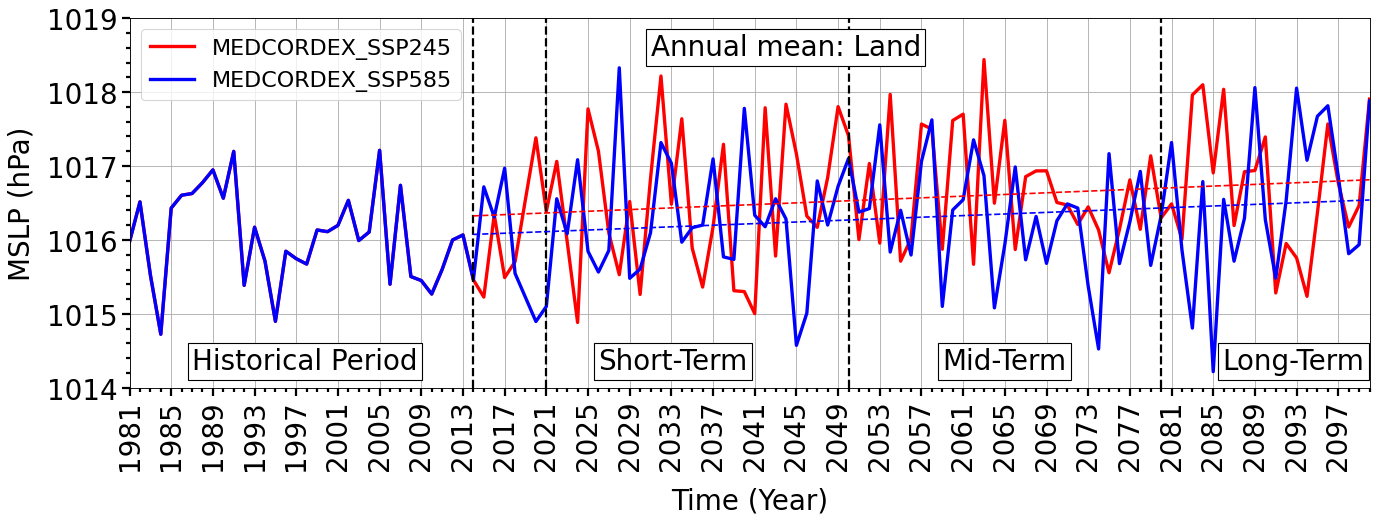

<Figure size 640x480 with 0 Axes>

In [27]:
################# Plot ###############
fig = plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace=0.6, wspace=0.1)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)

ax = fig.add_subplot(111)

ax.set_xlabel('Time (Year)',fontsize=25,labelpad=15)
ax.set_ylabel('MSLP (hPa)', fontsize=25,labelpad=10)
ax.tick_params(axis='y', colors='black', which='both', width=2)
ax.yaxis.label.set_color('black')
ax.set_xticks(np.arange(0,120,4))
ax.set_xlim(0,119)
years = np.arange(1981, 2101)
xtick_labels = [str(year) for year in years[::4]]
ax.set_xticklabels(xtick_labels, rotation=90)
#ax.set_xticklabels([str(year) if i % 3 == 0 else '' for i, year in enumerate(years)[::3]], rotation=90)
ax.grid(visible=True, which='major', linestyle='-')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)



ax.plot(np.arange(len(MSLP_medcordex_ssp245_lnd)), MSLP_medcordex_ssp245_lnd, linestyle='-', color='red', linewidth=3.0)
ax.plot(np.arange(len(MSLP_medcordex_ssp585_lnd)), MSLP_medcordex_ssp585_lnd, linestyle='-', color='blue', linewidth=3.0)


plt.legend(labels=['MEDCORDEX_SSP245','MEDCORDEX_SSP585'],loc='upper left', fontsize=20)

ax.set_ylim(1014,1019)
ax.set_yticks(np.arange(1014, 1020, 1))
ax.text(50, 1018.5, "Annual mean: Land", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

ax.plot([33, 33], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")
ax.plot([40, 40], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")
ax.plot([69, 69], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")
ax.plot([99, 99], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")

ax.text(6, 1014.25, "Historical Period", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))
ax.text(45, 1014.25, "Short-Term", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))
ax.text(78, 1014.25, "Mid-Term", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))
ax.text(104.9, 1014.25, "Long-Term", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

years = np.arange(2014, 2101)-2014
slope_trnd, intercept_trnd, r_value_trnd, p_value_trnd, std_err_trnd = linregress(years, MSLP_medcordex_ssp245_lnd[33::])
MSLP_medcordex_ssp245_lnd_trnd = intercept_trnd + slope_trnd * years
plt.plot(years+33, MSLP_medcordex_ssp245_lnd_trnd, '--', color='red')
print(slope_trnd)

slope_trnd, intercept_trnd, r_value_trnd, p_value_trnd, std_err_trnd = linregress(years, MSLP_medcordex_ssp585_lnd[33::])
MSLP_medcordex_ssp585_lnd_trnd = intercept_trnd + slope_trnd * years
plt.plot(years+33, MSLP_medcordex_ssp585_lnd_trnd, '--', color='blue')
print(slope_trnd)

plt.show()
plt.clf()

0.004658447683759158
0.004306454675725596


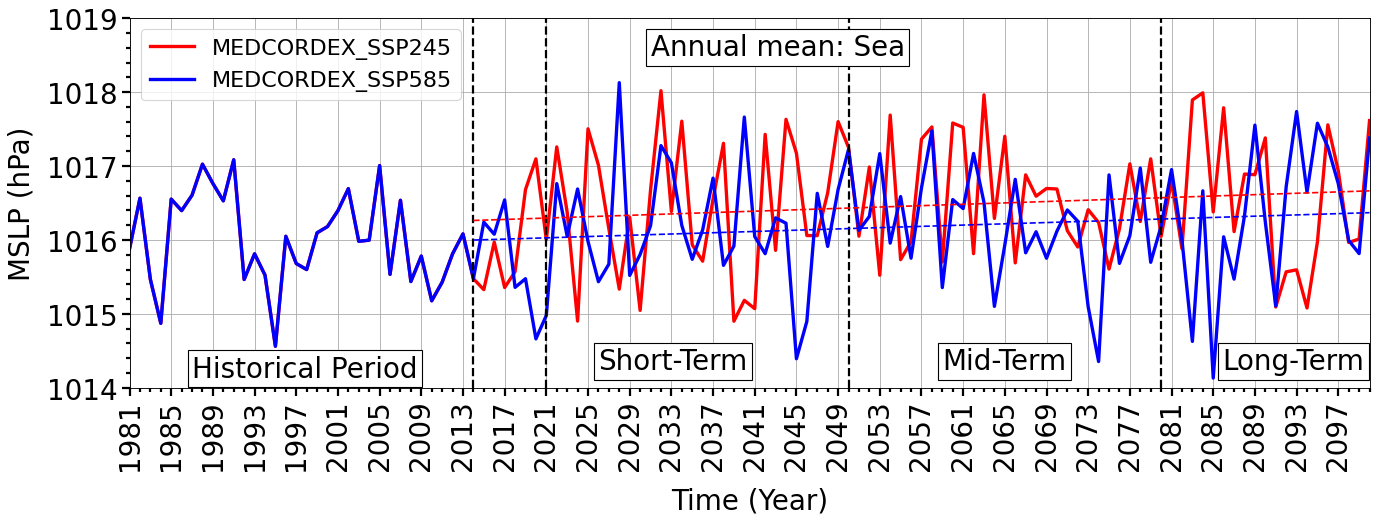

<Figure size 640x480 with 0 Axes>

In [32]:
################# Plot ###############
fig = plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace=0.6, wspace=0.1)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)

ax = fig.add_subplot(111)

ax.set_xlabel('Time (Year)',fontsize=25,labelpad=15)
ax.set_ylabel('MSLP (hPa)', fontsize=25,labelpad=10)
ax.tick_params(axis='y', colors='black', which='both', width=2)
ax.yaxis.label.set_color('black')
ax.set_xticks(np.arange(0,120,4))
ax.set_xlim(0,119)
years = np.arange(1981, 2101)
xtick_labels = [str(year) for year in years[::4]]
ax.set_xticklabels(xtick_labels, rotation=90)
#ax.set_xticklabels([str(year) if i % 3 == 0 else '' for i, year in enumerate(years)[::3]], rotation=90)
ax.grid(visible=True, which='major', linestyle='-')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)



ax.plot(np.arange(len(MSLP_medcordex_ssp245_ocn)), MSLP_medcordex_ssp245_ocn, linestyle='-', color='red', linewidth=3.0)
ax.plot(np.arange(len(MSLP_medcordex_ssp585_ocn)), MSLP_medcordex_ssp585_ocn, linestyle='-', color='blue', linewidth=3.0)


plt.legend(labels=['MEDCORDEX_SSP245','MEDCORDEX_SSP585'],loc='upper left', fontsize=20)

ax.set_ylim(1014,1019)
ax.set_yticks(np.arange(1014, 1020, 1))
ax.text(50, 1018.5, "Annual mean: Sea", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

ax.plot([33, 33], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")
ax.plot([40, 40], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")
ax.plot([69, 69], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")
ax.plot([99, 99], [1014, 1019], color='black', linestyle='--', linewidth=2, label="Marker Line")

ax.text(6, 1014.15, "Historical Period", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))
ax.text(45, 1014.25, "Short-Term", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))
ax.text(78, 1014.25, "Mid-Term", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))
ax.text(104.9, 1014.25, "Long-Term", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))


years = np.arange(2014, 2101)-2014
slope_trnd, intercept_trnd, r_value_trnd, p_value_trnd, std_err_trnd = linregress(years, MSLP_medcordex_ssp245_ocn[33::])
MSLP_medcordex_ssp245_ocn_trnd = intercept_trnd + slope_trnd * years
plt.plot(years+33, MSLP_medcordex_ssp245_ocn_trnd, '--', color='red')
print(slope_trnd)

slope_trnd, intercept_trnd, r_value_trnd, p_value_trnd, std_err_trnd = linregress(years, MSLP_medcordex_ssp585_ocn[33::])
MSLP_medcordex_ssp585_ocn_trnd = intercept_trnd + slope_trnd * years
plt.plot(years+33, MSLP_medcordex_ssp585_ocn_trnd, '--', color='blue')
print(slope_trnd)


plt.show()
plt.clf()